In [105]:
%%time
%matplotlib inline
from new_import import *


CPU times: user 631 µs, sys: 0 ns, total: 631 µs
Wall time: 643 µs


In [106]:
%%time
# Dask gateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,4))
dc = datacube.Datacube()

client

Starting new cluster.
CPU times: user 47.8 ms, sys: 8.17 ms, total: 56 ms
Wall time: 5.24 s


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.287223c209af4074946b7294c38dcd9c/status,


In [107]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2022-10-01')
longtitude_range = (105.86575, 105.94120)
latitude_range = (9.65070, 9.69850)

coordinates = (longtitude_range, latitude_range)

In [108]:
dsvh, dsvv = load_data_sen1(dc, date_range, coordinates)

<xarray.Dataset>
Dimensions:      (time: 3, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2022-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [109]:
average_vv = calculate_average(dsvv, time_pattern='1M')
progress(average_vv)


VBox()

In [110]:
average_vh = calculate_average(dsvh, time_pattern='1M')
progress(average_vh)

VBox()

In [111]:
%%time
average_vh.compute()
average_vv.compute()

CPU times: user 3.38 ms, sys: 8.79 ms, total: 12.2 ms
Wall time: 30.4 ms


<xarray.DataArray 'vv' (time: 1, y: 532, x: 830)>
array([[[0.19610517, 0.19610517, 0.20448251, ..., 0.08786568,
         0.08786568, 0.11003783],
        [0.21006434, 0.21006434, 0.22626366, ..., 0.08388788,
         0.08388788, 0.11941838],
        [0.21006434, 0.21006434, 0.22626366, ..., 0.08388788,
         0.08388788, 0.11941838],
        ...,
        [0.19183403, 0.19939446, 0.19939446, ..., 0.24768619,
         0.2261899 , 0.2261899 ],
        [0.19183403, 0.19939446, 0.19939446, ..., 0.24768619,
         0.2261899 , 0.2261899 ],
        [0.19183403, 0.19939446, 0.19939446, ..., 0.24768619,
         0.2261899 , 0.2261899 ]]], dtype=float32)
Coordinates:
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2022-09-30
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [112]:
data_sen2 = load_data_sen2(dc, date_range, coordinates)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))
display(data_sen2)

No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 6, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2022-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [113]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_cloud(data_sen2)
progress(result)

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 22.2 ms, sys: 0 ns, total: 22.2 ms
Wall time: 21.1 ms


VBox()

In [114]:
# calculate NDVI
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 6, y: 532, x: 830)>
dask.array<truediv, shape=(6, 532, 830), dtype=float32, chunksize=(1, 532, 830), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2022-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648

In [115]:
%%time
## tính ndvi theo tháng
average_ndvi = calculate_average(ndvi,time_pattern="1M")
progress(average_ndvi)

CPU times: user 9.91 ms, sys: 3.92 ms, total: 13.8 ms
Wall time: 12.9 ms


VBox()

In [116]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

(1, 532, 830)

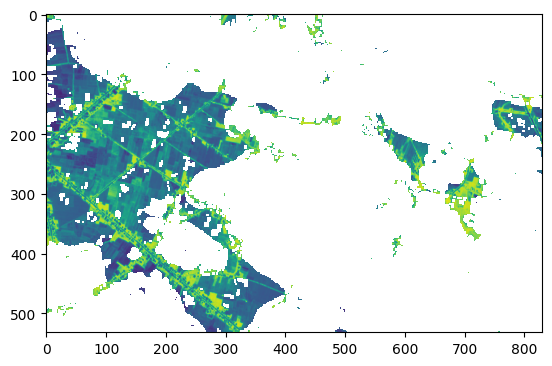

In [117]:
plt.imshow(average_ndvi.isel(time=0), vmin=None, vmax=None)
average_ndvi.shape

In [118]:
fill_nan_model = joblib.load('model_train/regressor/500points/fill_nan_model_gb.pkl')

In [119]:
mask = ~np.isnan(average_ndvi)

In [120]:
cloud_free_points = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)

In [121]:
# X_pred = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)
average_ndvi.values[~mask] = fill_nan_model.predict(cloud_free_points)
average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)

In [122]:
print(average_ndvi.shape, average_vh.shape, average_vv.shape)

(1, 532, 830) (1, 532, 830) (1, 532, 830)


In [123]:
thuanhoa_path = "ThuanHoa/region/ST_ThuanHoa_Boundaryofficially.shp"

In [ ]:
path = 'ThuanHoa/KhoanhDat/ThuanHoa_TKDD2022.shp'
TH = load_data_geo(path)
TH

In [142]:
# load model RF
loaded_model = joblib.load(os.path.join("model_train/new_classify", "classify_nb.joblib"))

In [143]:
%time
# dự đoán
data_array = predict(loaded_model, data_sen2.rio.crs, average_ndvi, average_vh, average_vv)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 18.4 µs


In [144]:
data_array

<xarray.DataArray (y: 532, x: 830)>
array([[3, 3, 3, ..., 6, 6, 3],
       [3, 3, 5, ..., 3, 3, 3],
       [3, 3, 9, ..., 3, 3, 3],
       ...,
       [3, 9, 9, ..., 5, 5, 5],
       [3, 9, 9, ..., 5, 5, 5],
       [3, 9, 9, ..., 5, 5, 5]])
Coordinates:
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
    spatial_ref  int64 0

In [145]:
import numpy as np
from collections import Counter

# Step 1: Convert xarray.DataArray to NumPy array
array_values = data_array.values

# Step 2: Flatten the array to 1D
flattened_array = array_values.flatten()

# Step 3: Use collections.Counter to count occurrences of each value
value_counts = Counter(flattened_array)

# Step 4: Find the most common value
most_common_value = value_counts.most_common(1)[0]  # (value, count)

print(f"The most common value is {most_common_value[0]} with {most_common_value[1]} occurrences.")
flattened_array.shape


The most common value is 3 with 231000 occurrences.


(441560,)

In [146]:
# cấu hình màu cho các loại đất
colors = [
    "#abcee9",
    "#fff",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "no label",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]

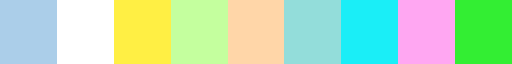

In [147]:
cmap

/tmp/ipykernel_142/2294385133.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


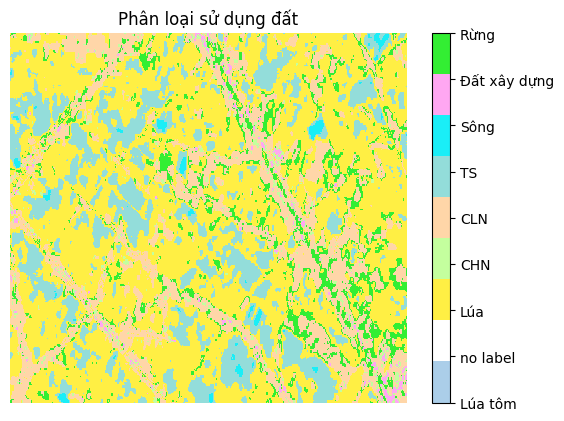

In [148]:
# hiển thị phân loại sử dụng đất
cmap = ListedColormap(colors)
img = data_array.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

In [133]:
# cắt theo ranh giới xã thuận hòa
region_result = cut_according_shp(thuanhoa_path, average_ndvi, data_array)

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [134]:
# Define options
colorval = list(range(len(colors)))

# Adjust options for better alignment in hvplot
options = {
    'title': 'Phân loại sử dụng đất',
    'cmap': colors,
    'clim': (1, 9),  # Make sure the color limit matches the number of classes
    'aspect': 'equal',
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),  # Label mapping
        'major_label_text_align': 'left',  # Text alignment
        'ticker': FixedTicker(ticks=colorval),  # Ensure correct ticks
    },
}

# Display land use classification result
region_result.hvplot(
    rasterize=True,                        # Use Datashader for large arrays
    aggregator=reductions.mode(),          # Datashader selects mode value
).options(opts.Image(**options))

:DynamicMap   []
   :Image   [x,y]   (value)

In [93]:
# Lưu lại kết quả
region_result.rio.to_raster("classify_results/new_result.tif")

In [ ]:
# đóng client, cluster
client.close()
cluster.close()